<a href="https://colab.research.google.com/github/sanaebenh/lab22/blob/main/lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install PyTorch
!pip install torch torchvision

In [ ]:
# Importation des bibliothèques nécessaires
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [ ]:
# Détection du GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation de l'appareil : {device}")

Utilisation de l'appareil : cuda


In [ ]:
# Normalisation des données : MNIST images (28x28) avec valeurs de pixel [0, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalisation : mean=0.5, std=0.5
])

# Téléchargement des ensembles de données MNIST
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Charger les données en mini-batches
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 453kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.18MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.50MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Convolution 1
        self.bn1 = nn.BatchNorm2d(32)  # Normalisation
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Convolution 2
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)  # Pooling (2x2)
        self.dropout = nn.Dropout(0.5)  # Dropout pour réduire l'overfitting
        self._compute_flattened_size()  # Calcul de la taille aplatie pour les couches fully connected
        self.fc1 = nn.Linear(self._flattened_size, 128)  # Fully connected 1
        self.fc2 = nn.Linear(128, 10)  # Fully connected 2 (10 classes)

    def _compute_flattened_size(self):
        with torch.no_grad():
            dummy_input = torch.randn(1, 1, 28, 28)  # Input dummy pour calculer la taille
            x = self.pool(self.bn1(torch.relu(self.conv1(dummy_input))))
            x = self.pool(self.bn2(torch.relu(self.conv2(x))))
            self._flattened_size = x.numel()  # Taille des features après convolution/pooling

    def forward(self, x):
        x = self.pool(self.bn1(torch.relu(self.conv1(x))))  # Convolution + Activation
        x = self.pool(self.bn2(torch.relu(self.conv2(x))))  # Convolution + Pooling
        x = x.view(x.size(0), -1)  # Aplatir les features
        x = torch.relu(self.fc1(x))  # Fully connected 1
        x = self.dropout(x)  # Dropout
        x = self.fc2(x)  # Fully connected 2 (logits)
        return x

# Instanciation du modèle
model = CNN().to(device)
print(model)


CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
# Fonction de perte et optimiseur
criterion = nn.CrossEntropyLoss()  # CrossEntropy pour classification multi-classes
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Adam Optimizer


In [ ]:
# Entraînement du modèle
num_epochs = 10  # Nombre d'époques

for epoch in range(num_epochs):
    model.train()  # Mode entraînement
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Charger les données sur GPU/CPU

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass et mise à jour
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Époque [{epoch+1}/{num_epochs}], Perte: {running_loss/len(train_loader):.4f}")


Époque [1/10], Perte: 0.1590
Époque [2/10], Perte: 0.0734
Époque [3/10], Perte: 0.0584
Époque [4/10], Perte: 0.0478
Époque [5/10], Perte: 0.0448
Époque [6/10], Perte: 0.0380
Époque [7/10], Perte: 0.0323
Époque [8/10], Perte: 0.0306
Époque [9/10], Perte: 0.0268
Époque [10/10], Perte: 0.0288


In [ ]:
# Fonction d'évaluation
def evaluate_model(model, test_loader):
    model.eval()  # Mode évaluation
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print(f"Test Loss: {test_loss / len(test_loader):.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    # Rapport de classification
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

# Évaluer le modèle
evaluate_model(model, test_loader)


Test Loss: 0.0307
Test Accuracy: 0.9924

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       1.00      0.99      0.99      1032
           3       0.99      1.00      1.00      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



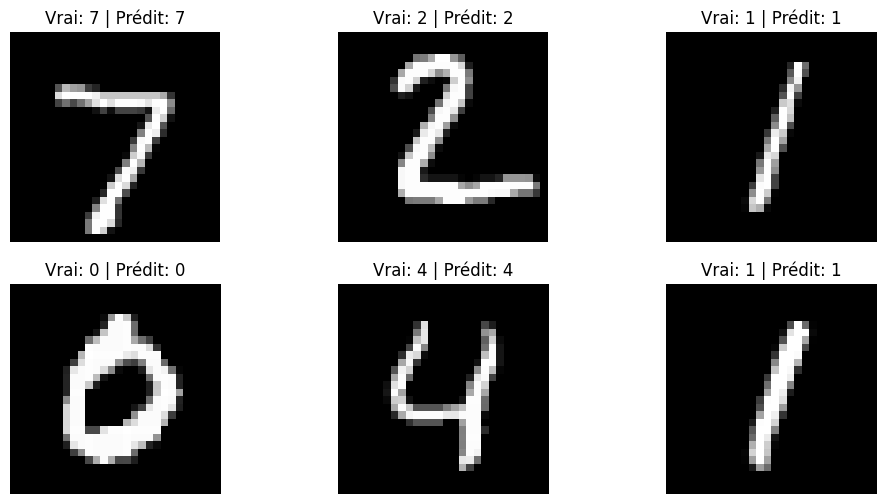

In [ ]:
# Visualisation des exemples de prédictions
def visualize_predictions(model, test_loader):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    # Affichage des 6 premières images
    plt.figure(figsize=(12, 6))
    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.imshow(images[i].cpu().squeeze(), cmap="gray")
        plt.title(f"Vrai: {labels[i].item()} | Prédit: {preds[i].item()}")
        plt.axis("off")
    plt.show()

# Visualiser les prédictions
visualize_predictions(model, test_loader)

In [ ]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Subset
import random
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
class MNISTDetectionDataset(torch.utils.data.Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        image, label = self.mnist_dataset[idx]

        # Convertir l'image en Tensor
        image = F.to_tensor(image)

        # Simuler une boîte englobante (bbox) pour la détection
        bbox = torch.tensor([[5, 5, 20, 20]], dtype=torch.float32)  # Box fictive pour démonstration

        # Préparer les cibles
        target = {
            "boxes": bbox,  # Une seule bbox pour MNIST
            "labels": torch.tensor([label], dtype=torch.int64),  # Classe associée
        }

        return image, target



In [ ]:
def create_subset(dataset, fraction=0.1, seed=42):
    random.seed(seed)
    indices = random.sample(range(len(dataset)), int(len(dataset) * fraction))
    return Subset(dataset, indices)


def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
# Charger le dataset complet
train_dataset = MNIST(root='./data', train=True, download=True)
test_dataset = MNIST(root='./data', train=False, download=True)

# Créer des sous-ensembles (10% des données)
train_subset = create_subset(train_dataset, fraction=0.1)
test_subset = create_subset(test_dataset, fraction=0.1)

# Adapter les sous-ensembles pour la détection d'objets
train_detection_dataset = MNISTDetectionDataset(train_subset)
test_detection_dataset = MNISTDetectionDataset(test_subset)

In [ ]:
# Créer les DataLoaders
train_loader = DataLoader(train_detection_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_detection_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Charger le modèle pré-entraîné
model = fasterrcnn_resnet50_fpn(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 158MB/s]


In [ ]:
# Ajuster le nombre de classes (10 pour MNIST + 1 pour la classe "fond")
num_classes = 10 + 1
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Envoyer le modèle sur le GPU ou le CPU
model = model.to(device)

# Hyperparamètres
num_epochs = 3
learning_rate = 0.001

In [ ]:
# Optimiseur
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=0.0005)



In [ ]:
def train_model(model, train_loader, optimizer, device, num_epochs=3):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for images, targets in train_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Calcul de la perte
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            # Rétropropagation
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            epoch_loss += losses.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}")


In [ ]:
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, targets in test_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            # Extraire les prédictions
            for i, output in enumerate(outputs):
                y_true.append(targets[i]['labels'][0].item())
                if len(output['labels']) > 0:  # Si une prédiction est faite
                    y_pred.append(output['labels'][0].item())  # Prendre la première prédiction
                else:  # Si aucune prédiction
                    y_pred.append(-1)  # Classe spéciale pour "aucune prédiction"

    # Calcul des métriques
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")


In [ ]:
train_model(model, train_loader, optimizer, device, num_epochs=num_epochs)
evaluate_model(model, test_loader, device)

Epoch [1/3], Loss: 0.1531
Epoch [2/3], Loss: 0.0579
Epoch [3/3], Loss: 0.0409
Accuracy: 0.8900, F1 Score: 0.8511


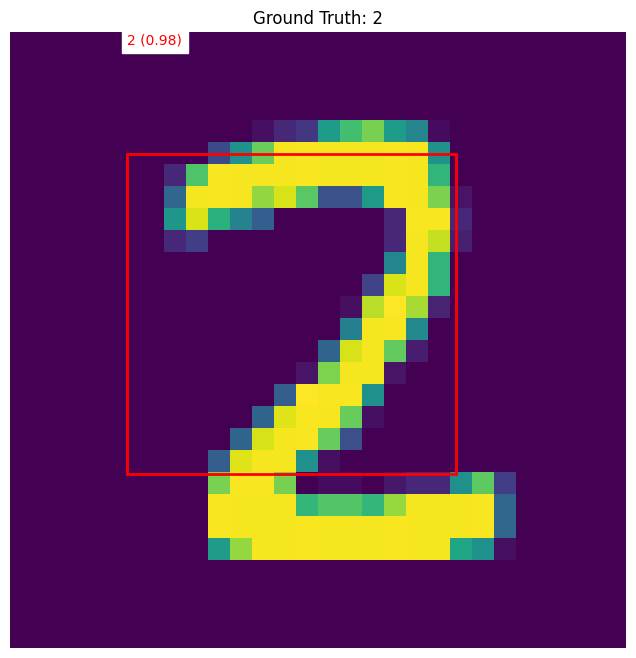

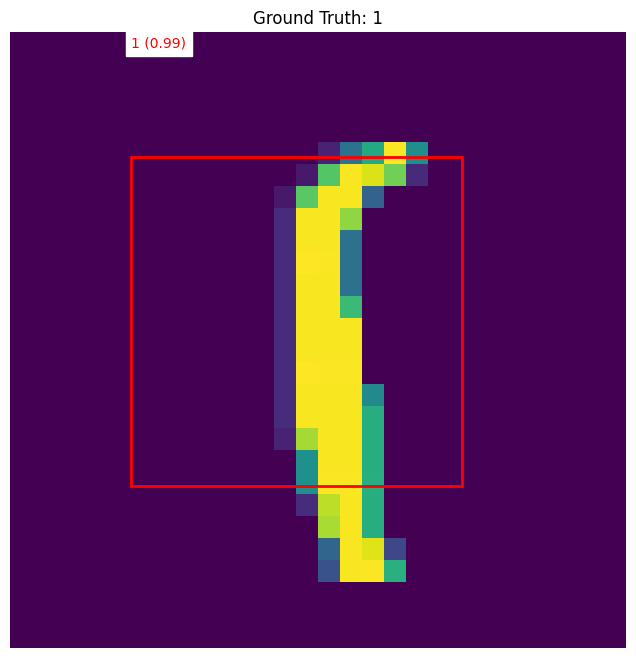

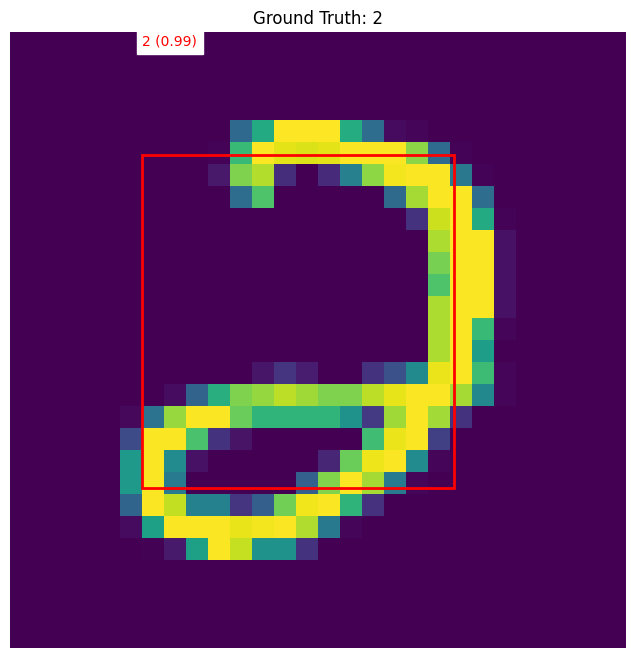

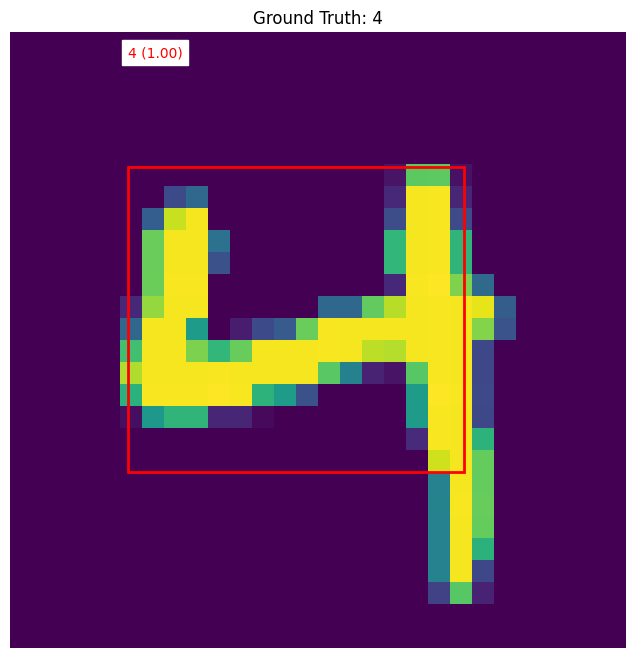

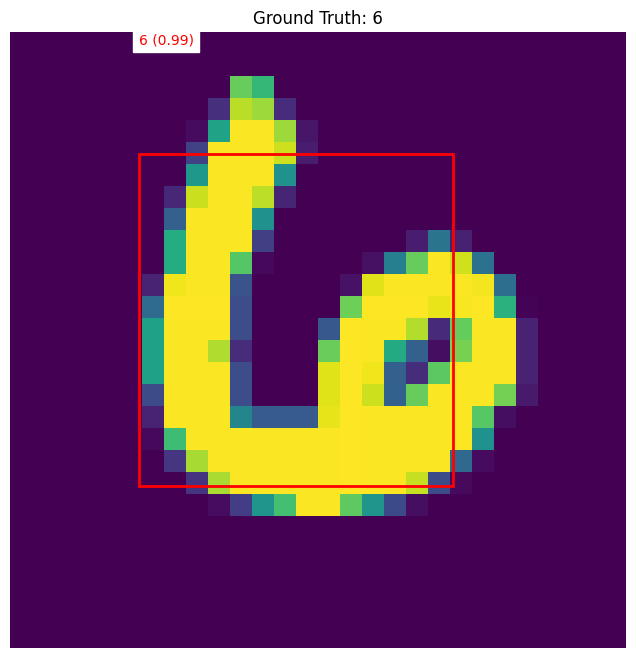

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def visualize_predictions(model, data_loader, device, num_images=5):
    """
    Visualise des exemples de prédictions effectuées par le modèle.
    Args:
        model: Le modèle Faster R-CNN.
        data_loader: DataLoader contenant les images de test.
        device: Le périphérique (CPU ou GPU).
        num_images: Nombre d'images à afficher.
    """
    model.eval()  # Met le modèle en mode évaluation
    images_shown = 0

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)  # Prédictions du modèle

            for i in range(len(images)):
                if images_shown >= num_images:
                    return

                image = images[i].cpu().permute(1, 2, 0).numpy()  # Convertir l'image pour matplotlib
                image = np.clip(image, 0, 1)  # Normaliser les valeurs d'image entre 0 et 1
                output = outputs[i]
                true_target = targets[i]

                # Préparer la figure
                fig, ax = plt.subplots(1, 1, figsize=(8, 8))
                ax.imshow(image)
                ax.axis("off")
                ax.set_title(f"Ground Truth: {true_target['labels'][0].item()}")

                # Boîte englobante et étiquette prédite
                if len(output["boxes"]) > 0:
                    for box, label, score in zip(output["boxes"], output["labels"], output["scores"]):
                        if score > 0.5:  # Seulement les prédictions avec un score élevé
                            x1, y1, x2, y2 = box.cpu().numpy()
                            width, height = x2 - x1, y2 - y1
                            rect = patches.Rectangle(
                                (x1, y1), width, height, linewidth=2, edgecolor="r", facecolor="none"
                            )
                            ax.add_patch(rect)
                            ax.text(
                                x1,
                                y1 - 5,
                                f"{label.item()} ({score:.2f})",
                                color="red",
                                fontsize=10,
                                backgroundcolor="white",
                            )
                else:
                    ax.text(
                        0.5,
                        0.5,
                        "No Prediction",
                        fontsize=12,
                        color="red",
                        ha="center",
                        va="center",
                        transform=ax.transAxes,
                    )

                plt.show()
                images_shown += 1

# Visualiser les prédictions
visualize_predictions(model, test_loader, device, num_images=5)


          Model  Accuracy (%)  F1 Score  Final Loss  Training Time (s)
0  Faster R-CNN          88.5    0.8507      0.0371               3360
1    Simple CNN          98.0    0.9800      0.0245                120


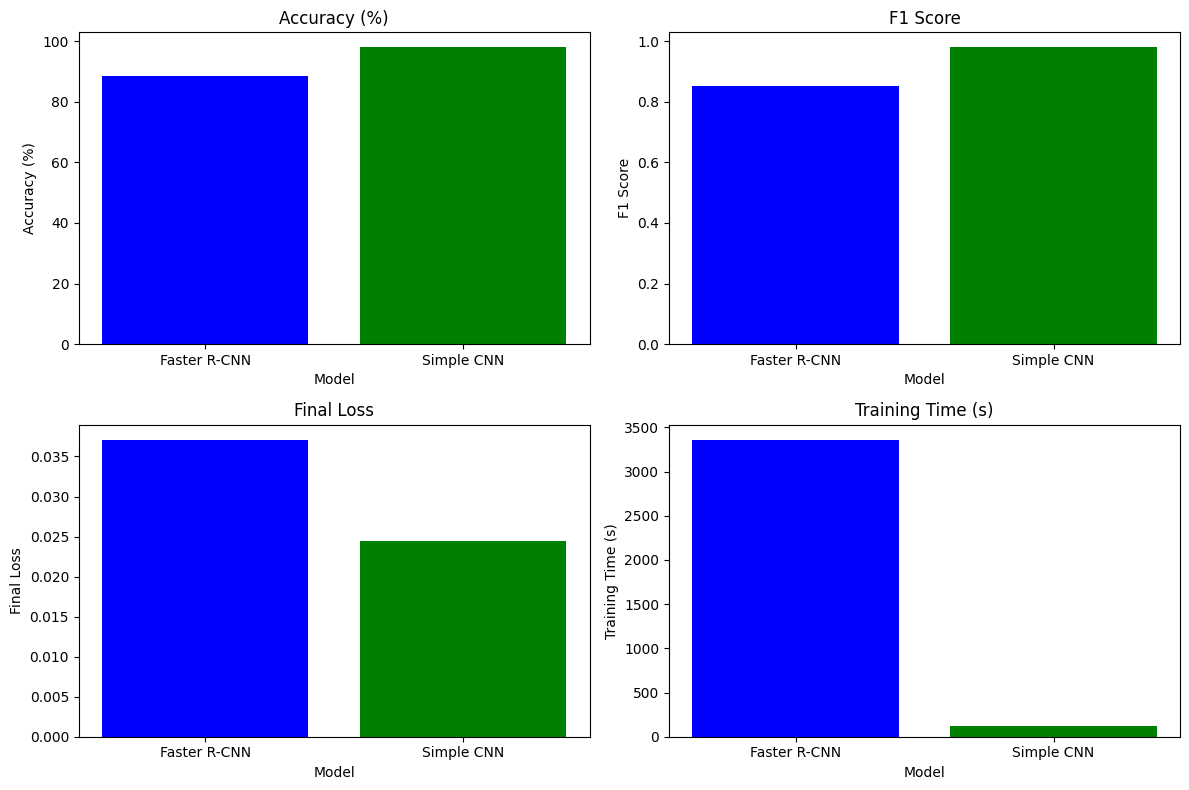

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Métriques des deux modèles
data = {
    "Model": ["Faster R-CNN", "Simple CNN"],
    "Accuracy (%)": [88.50, 98.00],
    "F1 Score": [0.8507, 0.9800],
    "Final Loss": [0.0371, 0.0245],
    "Training Time (s)": [3360,120 ],
}

# Création d'un DataFrame
comparison_df = pd.DataFrame(data)

# Afficher les résultats sous forme de tableau
print(comparison_df)

# Visualisation avec un graphique en barres
metrics = ["Accuracy (%)", "F1 Score", "Final Loss", "Training Time (s)"]

# Tracer les métriques
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    axes[i].bar(comparison_df["Model"], comparison_df[metric], color=["blue", "green"])
    axes[i].set_title(metric)
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel("Model")

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torchvision
from torchvision import transforms
from torchvision.models import vgg16, alexnet
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from sklearn.metrics import accuracy_score, f1_score
import time
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Définir l'appareil
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prétraitement des données
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convertir en 3 canaux
    transforms.Resize((224, 224)),  # Redimensionner pour VGG16 et AlexNet
    transforms.ToTensor()
])


In [ ]:
# Charger le dataset MNIST
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
# Fonction pour fine-tuner les modèles
def fine_tune_model(model_name, num_classes, device):
    if model_name == "VGG16":
        model = vgg16(pretrained=True)
        model.classifier[6] = torch.nn.Linear(4096, num_classes)  # Adapter à 10 classes
    elif model_name == "AlexNet":
        model = alexnet(pretrained=True)
        model.classifier[6] = torch.nn.Linear(4096, num_classes)  # Adapter à 10 classes
    else:
        raise ValueError("Modèle non pris en charge")
    return model.to(device)


In [ ]:
# Fonction d'entraînement
def train_model(model, train_loader, optimizer, device, num_epochs=3):
    model.train()
    start_time = time.time()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = torch.nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}")
    training_time = time.time() - start_time
    return training_time


In [ ]:
# Fonction d'évaluation
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")
    return accuracy, f1


In [ ]:
# Initialisation des résultats
results = []

# Modèles à comparer
models_to_train = [
    {"name": "VGG16", "model": fine_tune_model("VGG16", num_classes=10, device=device)},
    {"name": "AlexNet", "model": fine_tune_model("AlexNet", num_classes=10, device=device)},
]

In [ ]:
# Entraînement et évaluation
for model_info in models_to_train:
    model_name = model_info["name"]
    model = model_info["model"]
    print(f"Training {model_name}...")
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    training_time = train_model(model, train_loader, optimizer, device, num_epochs=3)
    accuracy, f1 = evaluate_model(model, test_loader, device)
    print(f"{model_name} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    results.append({"Model": model_name, "Accuracy": accuracy, "F1 Score": f1, "Training Time (s)": training_time})


Training VGG16...
Epoch [1/3], Loss: 0.0871
Epoch [2/3], Loss: 0.0227
Epoch [3/3], Loss: 0.0150
VGG16 - Accuracy: 0.9945, F1 Score: 0.9945
Training AlexNet...
Epoch [1/3], Loss: 0.1088
Epoch [2/3], Loss: 0.0344
Epoch [3/3], Loss: 0.0262
AlexNet - Accuracy: 0.9943, F1 Score: 0.9943



Comparison of Models:
          Model  Accuracy  F1 Score  Training Time (s)
0         VGG16    0.9945  0.994497        2638.938926
1       AlexNet    0.9943  0.994299         386.013927
2    Simple CNN    0.9800  0.980000         120.000000
3  Faster R-CNN    0.8850  0.850700        3360.000000


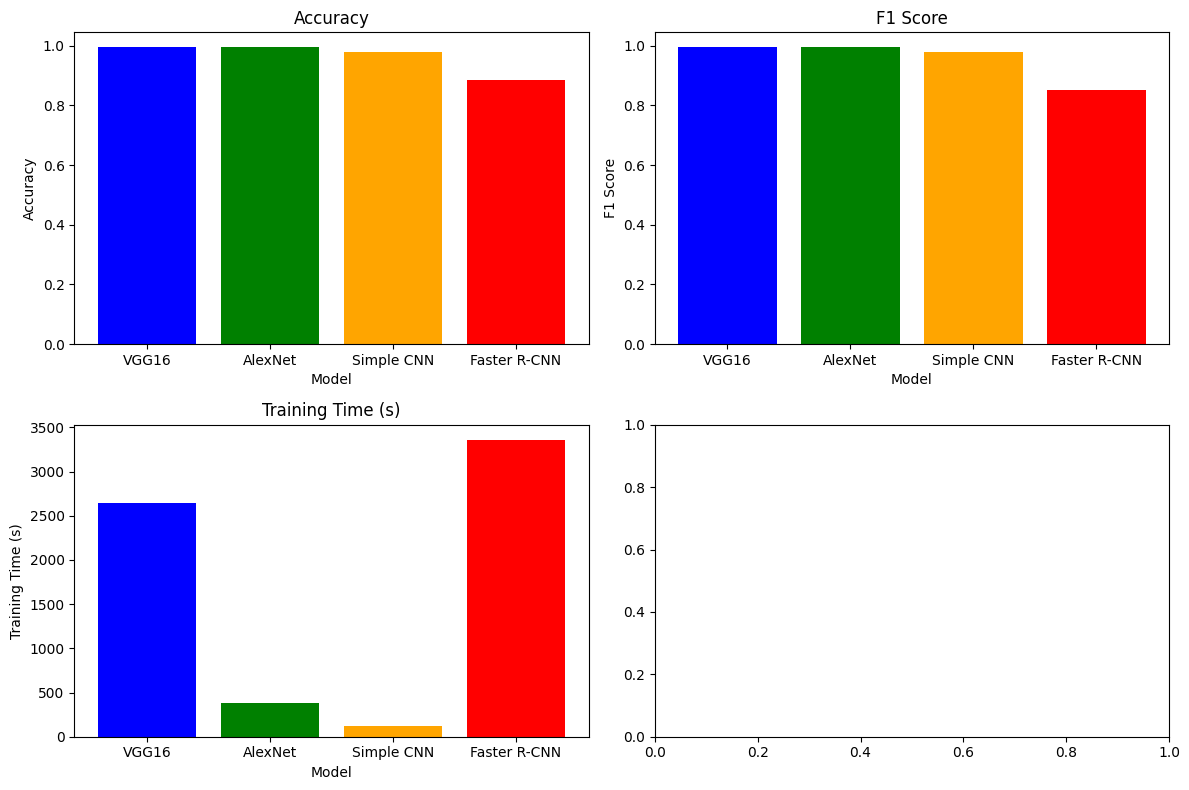

In [ ]:
# Ajout des résultats de CNN et Faster R-CNN
results.extend([
    {"Model": "Simple CNN", "Accuracy": 0.98, "F1 Score": 0.9800, "Training Time (s)": 120},  # Remplir avec vos valeurs
    {"Model": "Faster R-CNN", "Accuracy": 0.885, "F1 Score": 0.8507, "Training Time (s)": 3360}  # Remplir avec vos valeurs
])

# Créer un DataFrame pour les résultats
results_df = pd.DataFrame(results)

# Afficher les résultats
print("\nComparison of Models:")
print(results_df)

# Visualisation des résultats
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

metrics = ["Accuracy", "F1 Score", "Training Time (s)"]

for i, metric in enumerate(metrics):
    axes[i].bar(results_df["Model"], results_df[metric], color=["blue", "green", "orange", "red"])
    axes[i].set_title(metric)
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel("Model")

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt


In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------
# 1. Data Preparation
# -------------------------------

# Transformation for MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # Normalize to [-1, 1]
])

In [ ]:
# Load MNIST dataset
train_dataset = MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = MNIST(root="./data", train=False, transform=transform, download=True)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
# -------------------------------
# 2. Vision Transformer Components
# -------------------------------

# Patch Embedding
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=28, patch_size=7, in_channels=1, embedding_dim=64):
        super().__init__()
        self.n_patches = (img_size // patch_size) ** 2
        self.projection = nn.Conv2d(in_channels, embedding_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.projection(x)  # Shape: (batch_size, embedding_dim, n_patches ** 0.5, n_patches ** 0.5)
        x = x.flatten(2).transpose(1, 2)  # Shape: (batch_size, n_patches, embedding_dim)
        return x

# Multi-Head Self-Attention
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embedding_dim // num_heads

        self.query = nn.Linear(embedding_dim, embedding_dim)
        self.key = nn.Linear(embedding_dim, embedding_dim)
        self.value = nn.Linear(embedding_dim, embedding_dim)
        self.fc_out = nn.Linear(embedding_dim, embedding_dim)

    def forward(self, x):
        batch_size, n_patches, embedding_dim = x.shape
        q = self.query(x).reshape(batch_size, n_patches, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        k = self.key(x).reshape(batch_size, n_patches, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v = self.value(x).reshape(batch_size, n_patches, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        attention = torch.einsum("bhqd, bhkd -> bhqk", q, k) / (self.head_dim ** 0.5)
        attention = torch.nn.functional.softmax(attention, dim=-1)
        out = torch.einsum("bhqk, bhvd -> bhqd", attention, v)
        out = out.permute(0, 2, 1, 3).reshape(batch_size, n_patches, embedding_dim)
        return self.fc_out(out)

# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, embedding_dim, num_heads, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadSelfAttention(embedding_dim, num_heads)
        self.norm1 = nn.LayerNorm(embedding_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim * 4),
            nn.GELU(),
            nn.Linear(embedding_dim * 4, embedding_dim),
        )
        self.norm2 = nn.LayerNorm(embedding_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attention = self.attention(x)
        x = self.norm1(x + self.dropout(attention))
        forward = self.mlp(x)
        x = self.norm2(x + self.dropout(forward))
        return x


In [ ]:
# Vision Transformer
class VisionTransformer(nn.Module):
    def __init__(self, img_size=28, patch_size=7, in_channels=1, num_classes=10, embedding_dim=64, num_heads=8, depth=6, dropout=0.1):
        super().__init__()
        self.patch_embedding = PatchEmbedding(img_size, patch_size, in_channels, embedding_dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim))
        self.positional_encoding = nn.Parameter(torch.randn(1, 1 + self.patch_embedding.n_patches, embedding_dim))
        self.transformer = nn.Sequential(*[TransformerBlock(embedding_dim, num_heads, dropout) for _ in range(depth)])
        self.fc = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.patch_embedding(x)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # Shape: (batch_size, 1, embedding_dim)
        x = torch.cat([cls_tokens, x], dim=1)  # Append cls_token
        x += self.positional_encoding[:, : x.shape[1], :]
        x = self.transformer(x)
        cls_output = x[:, 0]  # Extract cls_token output
        return self.fc(cls_output)

In [ ]:
# -------------------------------
# 3. Training and Evaluation
# -------------------------------

def train_model(model, train_loader, optimizer, device, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}")

def evaluate_model(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")
    print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

# Initialize and train the Vision Transformer
model = VisionTransformer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
train_model(model, train_loader, optimizer, device, num_epochs=5)
evaluate_model(model, test_loader, device)

Epoch [1/5], Loss: 1.4821
Epoch [2/5], Loss: 0.8450
Epoch [3/5], Loss: 0.5018
Epoch [4/5], Loss: 0.3636
Epoch [5/5], Loss: 0.3068
Accuracy: 0.9177, F1 Score: 0.9177


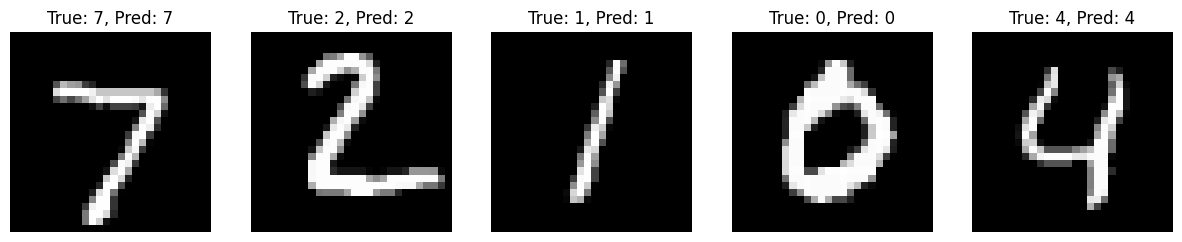

In [ ]:
# -------------------------------
# 4. Visualization of Results
# -------------------------------

# Visualizing sample predictions
model.eval()
images, labels = next(iter(test_loader))
images = images.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(images[i].cpu().squeeze(), cmap="gray")
    axes[i].set_title(f"True: {labels[i].item()}, Pred: {preds[i].item()}")
    axes[i].axis("off")
plt.show()